# 1. Import Libraries

In [1]:
# Import relevant libraries.
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter, YearLocator
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from sklearn import datasets 
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Ignore
import warnings
warnings.filterwarnings('ignore')


# 2. Prepare Work Station

## Sentiment Score Ready Document

In [3]:
# Load the CSV file
bert_sentiment_uk = pd.read_csv('bert_sentiment_uk.csv')

# View the data frame
bert_sentiment_uk.head()
print(bert_sentiment_uk.info)


<bound method DataFrame.info of          reference         country        date quarter  year_month    weekday  \
0     r980915a_BOE  united kingdom  1998-09-15  1998Q3  1998-09-01    Tuesday   
1     r981021b_BOE  united kingdom  1998-10-21  1998Q4  1998-10-01  Wednesday   
2     r981021a_BOE  united kingdom  1998-10-21  1998Q4  1998-10-01  Wednesday   
3     r981101a_BOE  united kingdom  1998-11-01  1998Q4  1998-11-01     Sunday   
4     r981101b_BOE  united kingdom  1998-11-01  1998Q4  1998-11-01     Sunday   
...            ...             ...         ...     ...         ...        ...   
1204  r221007a_BOE  united kingdom  2022-10-07  2022Q4  2022-10-01     Friday   
1205  r221012a_BOE  united kingdom  2022-10-12  2022Q4  2022-10-01  Wednesday   
1206  r221015a_BOE  united kingdom  2022-10-15  2022Q4  2022-10-01   Saturday   
1207  r221019a_BOE  united kingdom  2022-10-19  2022Q4  2022-10-01  Wednesday   
1208  r221020a_BOE  united kingdom  2022-10-20  2022Q4  2022-10-01   Thursday

In [5]:
# Check the column
bert_sentiment_uk['finbert_score'].describe()


count    1209.000000
mean       -0.019131
std         0.258998
min        -0.950714
25%        -0.055153
50%         0.023241
75%         0.090172
max         0.904649
Name: finbert_score, dtype: float64

In [7]:
# Check the time frame of the speeches
print("The speeches range from " + str(bert_sentiment_uk['date'].min()) + " to " + str(bert_sentiment_uk['date'].max())+ ".")


The speeches range from 1998-09-15 to 2022-10-20.


In [9]:
# Create monthly average FinBert score DataFrame 
avg_bert = pd.DataFrame(bert_sentiment_uk.groupby('year_month')['finbert_score'].mean())

# Create quarterly average Finbert score DataFrame
quart_bert = bert_sentiment_uk.groupby('quarter')['finbert_score'].mean().reset_index()

# Ensure that 'quarter' is in a Period format if it's not already
if quart_bert['quarter'].dtype != 'period[Q]':
    quart_bert['quarter'] = pd.PeriodIndex(quart_bert['quarter'], freq='Q')

# Convert 'quarter' to a timestamp
quart_bert['quarter'] = quart_bert['quarter'].dt.to_timestamp()

# View the new DataFrame
quart_bert.head()


,quarter,finbert_score
0,1998-07-01,-0.237672
1,1998-10-01,-0.116431
2,1999-01-01,0.041918
3,1999-04-01,0.053082
4,1999-07-01,-0.007517


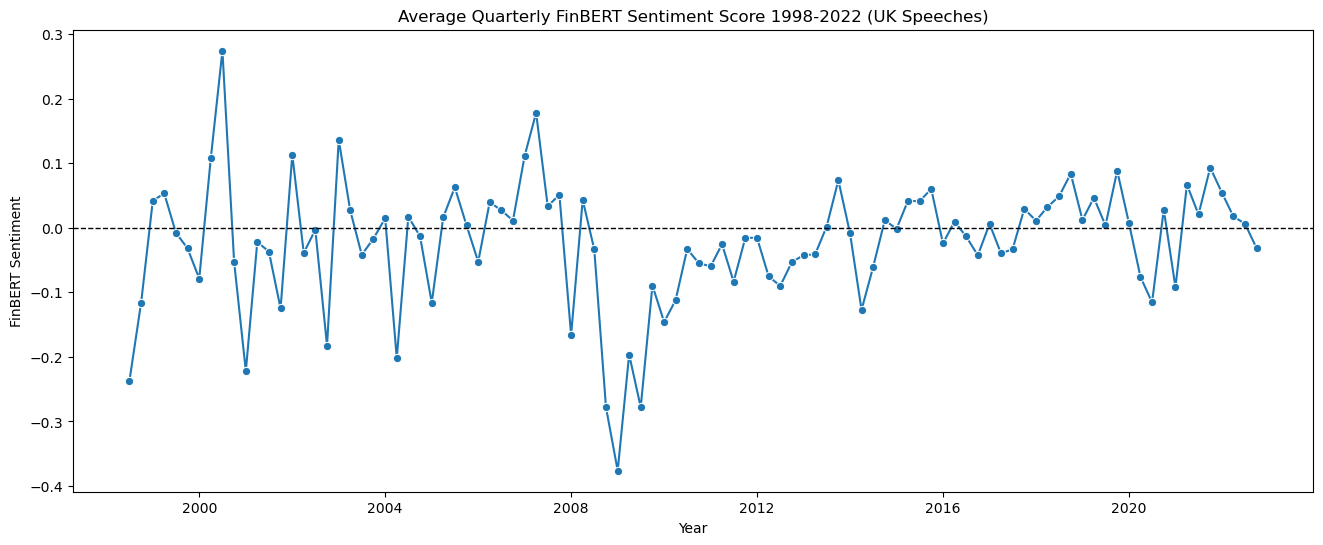

In [11]:
# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=quart_bert, x='quarter', y='finbert_score', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('Average Quarterly FinBERT Sentiment Score 1998-2022 (UK Speeches)')

# Display the plot
plt.show()


## GBP_USD Exchange Rate

In [13]:
# Load the CSV file(s) as reviews.
Exchange = pd.read_excel('GBPUSDPriceHistory.xlsx') 

# View the DataFrame.
print(Exchange.head())
print(Exchange.info())
Exchange.describe() 


        Date  Bid  Ask       Mid    Change   % Change  Cumulative Change %  \
0 1985-01-31  NaN  NaN  1.128999       NaN        NaN                  NaN   
1 1985-02-28  NaN  NaN  1.087000 -0.041999  -3.720037            -3.720037   
2 1985-03-29  NaN  NaN  1.233000  0.146000  13.431431             9.211740   
3 1985-04-30  NaN  NaN  1.245000  0.012000   0.973220            10.274610   
4 1985-05-31  NaN  NaN  1.283499  0.038499   3.092322            13.684656   

       High     Low  
0  1.158749  1.1145  
1  1.128999  1.0385  
2  1.233000  1.0585  
3  1.298000  1.2020  
4  1.287000  1.2085  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 478 non-null    datetime64[ns]
 1   Bid                  370 non-null    float64       
 2   Ask                  370 non-null    float64       
 3   Mid  

,Date,Bid,Ask,Mid,Change,% Change,Cumulative Change %,High,Low
count,478,370.000000,370.000000,478.000000,477.000000,477.000000,477.000000,478.000000,478.000000
mean,2004-12-14 05:52:28.117154816,1.543340,1.543851,1.563218,0.000358,0.069146,38.541096,1.588717,1.533792
min,1985-01-31 00:00:00,1.116100,1.116500,1.087000,-0.214499,-12.074262,-3.720037,1.128999,1.038500
25%,1995-01-07 00:00:00,1.378075,1.378550,1.422825,-0.024499,-1.515564,26.085060,1.452213,1.401575
50%,2004-12-15 12:00:00,1.558300,1.558750,1.567400,-0.000700,-0.044742,38.884056,1.594000,1.542200
75%,2014-11-21 00:00:00,1.642975,1.643600,1.674674,0.028500,1.920267,48.334849,1.694374,1.637349
max,2024-10-17 00:00:00,2.077100,2.077600,2.077350,0.146000,13.431431,83.999205,2.108200,2.045450
std,NaN,0.204370,0.204387,0.203164,0.044718,2.812442,17.927310,0.206117,0.200755


In [15]:
# Filter the DataFrame for data from 1998 Q3 onwards
GBPUSD_after1998 = Exchange[Exchange['Date'] > '1998-08-31'].reset_index(drop=True)

# Reserve necessary columns
GBPUSD_after1998 = GBPUSD_after1998[['Date','Mid']]

# Display the subset of data
print(GBPUSD_after1998)


          Date       Mid
0   1998-09-30  1.699400
1   1998-10-30  1.674700
2   1998-11-30  1.650601
3   1998-12-31  1.663799
4   1999-01-29  1.642799
..         ...       ...
309 2024-06-28  1.264100
310 2024-07-31  1.284450
311 2024-08-30  1.314250
312 2024-09-30  1.341350
313 2024-10-17  1.299750

[314 rows x 2 columns]


In [17]:
# Change the date format
GBPUSD_after1998['Date'] = pd.PeriodIndex(GBPUSD_after1998['Date'], freq='Q')

# Create quarterly average DataFrame
quart_GBPUSD_after1998 = GBPUSD_after1998.groupby('Date')['Mid'].mean().reset_index()

# Ensure that 'quarter' is in a Period format if it's not already
# if quart_GBPUSD_after1998['Date'].dtype != 'period[Q]':
  #  quart_GBPUSD_after1998['Date'] = pd.PeriodIndex(quart_GBPUSD_after1998['Date'], freq='Q')

# Convert 'Date' from Period to datetime if needed
quart_GBPUSD_after1998['Date'] = quart_GBPUSD_after1998['Date'].dt.to_timestamp()

# Rename Date column
quart_GBPUSD_after1998 = quart_GBPUSD_after1998.rename(columns = {'Date':'quarter','Mid':'GBP/USD'})

# View the new DataFrame
quart_GBPUSD_after1998.head()


,quarter,GBP/USD
0,1998-07-01,1.699400
1,1998-10-01,1.663033
2,1999-01-01,1.619699
3,1999-04-01,1.596567
4,1999-07-01,1.624967


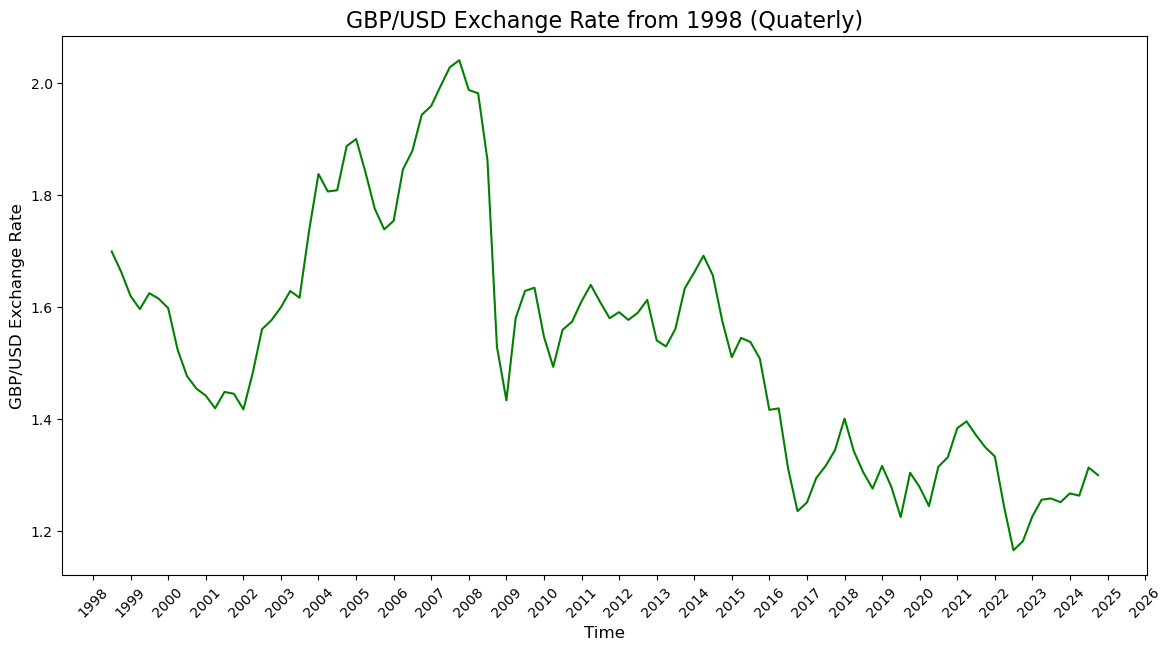

In [19]:
# Set the frame size
plt.figure(figsize=(14, 7))

# Create a lineplot.
plt.plot(quart_GBPUSD_after1998['quarter'], quart_GBPUSD_after1998['GBP/USD'], color='green', linestyle='-')

# Set the title
plt.title('GBP/USD Exchange Rate from 1998 (Quaterly)', fontsize=16)

# Set the xlabel
plt.xlabel('Time', fontsize=12)

# Set the ylabel
plt.ylabel('GBP/USD Exchange Rate', fontsize=12)

# Set the x-axis tick frequency to show ticks at every year
locator = YearLocator()
formatter = DateFormatter('%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Increase the number of x-axis labels
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()


## Unemployment Rate

In [21]:
# Load the dataset to inspect its contents
data = pd.read_csv('16_64_quarterly_data.csv')

# Display the first few rows of the dataset to understand its structure
data.head()


,Period,All aged 16 to 64 (level),Total economically active (16 to 64),Total in employment (16 to 64),Unemployed (16 to 64),Economically inactive (16 to 64),Economic activity rate (16 to 64),Employment rate (16 to 64),Unemployment rate (16 to 64),Economic inactivity rate (16 to 64)
0,Jan-Mar 1971,33559000.0,25187000.0,24219000.0,967000.0,8373000.0,75.1,72.2,3.8,24.9
1,Apr-Jun 1971,33576000.0,25199000.0,24168000.0,1031000.0,8377000.0,75.1,72.0,4.1,24.9
2,Jul-Sep 1971,33589000.0,25148000.0,24085000.0,1063000.0,8440000.0,74.9,71.7,4.2,25.1
3,Oct-Dec 1971,33596000.0,25137000.0,24017000.0,1120000.0,8459000.0,74.8,71.5,4.5,25.2
4,Jan-Mar 1972,33603000.0,25257000.0,24115000.0,1142000.0,8346000.0,75.2,71.8,4.5,24.8


In [23]:
# Extract year and quarter properly from the 'Period' column
# Periods are like "Jan-Mar 1971", so we will extract year and map months correctly
def convert_quarter_to_month(quarter):
    if 'Jan-Mar' in quarter:
        return '02'  # February as a mid-point for Q1
    elif 'Apr-Jun' in quarter:
        return '05'  # May as a mid-point for Q2
    elif 'Jul-Sep' in quarter:
        return '08'  # August as a mid-point for Q3
    elif 'Oct-Dec' in quarter:
        return '11'  # November as a mid-point for Q4
    return None

# Extract the year and corresponding month based on the quarter
data['Year'] = data['Period'].str[-4:]  # Extracting the year part
data['Month'] = data['Period'].apply(lambda x: convert_quarter_to_month(x))

# Create a cleaned Period column for plotting
data['Period_Clean'] = pd.to_datetime(data['Year'] + '-' + data['Month'] + '-01', format='%Y-%m-%d', errors='coerce')

# Check the wrangled DataFrame
data.head()


,Period,All aged 16 to 64 (level),Total economically active (16 to 64),Total in employment (16 to 64),Unemployed (16 to 64),Economically inactive (16 to 64),Economic activity rate (16 to 64),Employment rate (16 to 64),Unemployment rate (16 to 64),Economic inactivity rate (16 to 64),Year,Month,Period_Clean
0,Jan-Mar 1971,33559000.0,25187000.0,24219000.0,967000.0,8373000.0,75.1,72.2,3.8,24.9,1971,02,1971-02-01
1,Apr-Jun 1971,33576000.0,25199000.0,24168000.0,1031000.0,8377000.0,75.1,72.0,4.1,24.9,1971,05,1971-05-01
2,Jul-Sep 1971,33589000.0,25148000.0,24085000.0,1063000.0,8440000.0,74.9,71.7,4.2,25.1,1971,08,1971-08-01
3,Oct-Dec 1971,33596000.0,25137000.0,24017000.0,1120000.0,8459000.0,74.8,71.5,4.5,25.2,1971,11,1971-11-01
4,Jan-Mar 1972,33603000.0,25257000.0,24115000.0,1142000.0,8346000.0,75.2,71.8,4.5,24.8,1972,02,1972-02-01


In [25]:
# Filter the data for the past 5 years
Unemployment_after1998 = data[data['Period_Clean'] >= pd.to_datetime('1998-08-01')]

# View the new DataFrame
Unemployment_after1998.head()


,Period,All aged 16 to 64 (level),Total economically active (16 to 64),Total in employment (16 to 64),Unemployed (16 to 64),Economically inactive (16 to 64),Economic activity rate (16 to 64),Employment rate (16 to 64),Unemployment rate (16 to 64),Economic inactivity rate (16 to 64),Year,Month,Period_Clean
110,Jul-Sep 1998,36901140.0,2.817972e+07,2.640697e+07,1.772750e+06,8.721420e+06,76.365447,71.561396,6.290870,23.634553,1998,08,1998-08-01
111,Oct-Dec 1998,36950775.0,2.827795e+07,2.652413e+07,1.753814e+06,8.672828e+06,76.528698,71.782347,6.202054,23.471302,1998,11,1998-11-01
112,Jan-Mar 1999,37001895.0,2.835726e+07,2.658918e+07,1.768080e+06,8.644632e+06,76.637325,71.858977,6.235015,23.362675,1999,02,1999-02-01
113,Apr-Jun 1999,37052328.0,2.836848e+07,2.663592e+07,1.732569e+06,8.683844e+06,76.563297,71.887293,6.107371,23.436703,1999,05,1999-05-01
114,Jul-Sep 1999,37106092.0,2.844788e+07,2.675997e+07,1.687915e+06,8.658209e+06,76.666341,72.117453,5.933357,23.333659,1999,08,1999-08-01


In [27]:
# Check the range of employment rate (16 to 64)
Unemployment_after1998['Unemployment rate (16 to 64)'].describe()


count    104.000000
mean       5.615315
std        1.334840
min        3.831005
25%        4.737971
50%        5.242640
75%        6.169216
max        8.553393
Name: Unemployment rate (16 to 64), dtype: float64

In [29]:
# Create a new DataFrame (reduce columns in the original DataFrame)
quart_unemployment = Unemployment_after1998[['Period_Clean','Unemployment rate (16 to 64)']].reset_index(drop=True)

# Rename columns 
quart_unemployment = quart_unemployment.rename(columns={'Period_Clean': 'quarter', 'Unemployment rate (16 to 64)': 'Unemployment rate %'})

# View the new DataFrame
quart_unemployment.head()


,quarter,Unemployment rate %
0,1998-08-01,6.290870
1,1998-11-01,6.202054
2,1999-02-01,6.235015
3,1999-05-01,6.107371
4,1999-08-01,5.933357


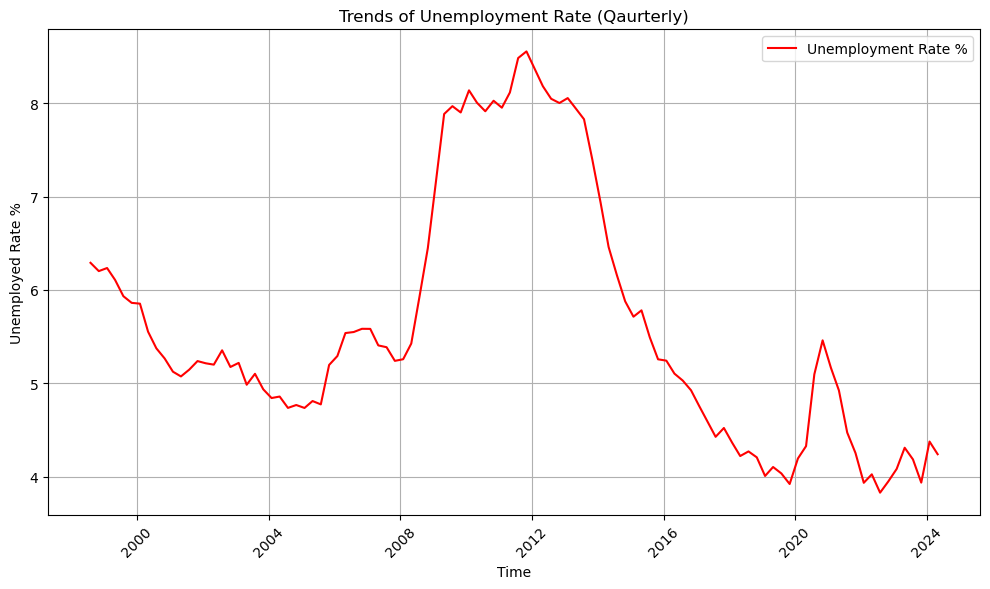

In [31]:
# Plot the unemployment trends over time with the cleaned period
plt.figure(figsize=(10, 6))
plt.plot(quart_unemployment['quarter'], quart_unemployment['Unemployment rate %'], label='Unemployment Rate %', color='red')
plt.title('Trends of Unemployment Rate (Qaurterly)')
plt.xlabel('Time')
plt.ylabel('Unemployed Rate %')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3. Plot Sentiment Score and Economic Indicators

## FinBert Score & Unemployment Rate

In [33]:
# View the relevant DataFrame
quart_bert.head()


,quarter,finbert_score
0,1998-07-01,-0.237672
1,1998-10-01,-0.116431
2,1999-01-01,0.041918
3,1999-04-01,0.053082
4,1999-07-01,-0.007517


In [35]:
# View the relevant DataFrame
quart_unemployment.head()


,quarter,Unemployment rate %
0,1998-08-01,6.290870
1,1998-11-01,6.202054
2,1999-02-01,6.235015
3,1999-05-01,6.107371
4,1999-08-01,5.933357


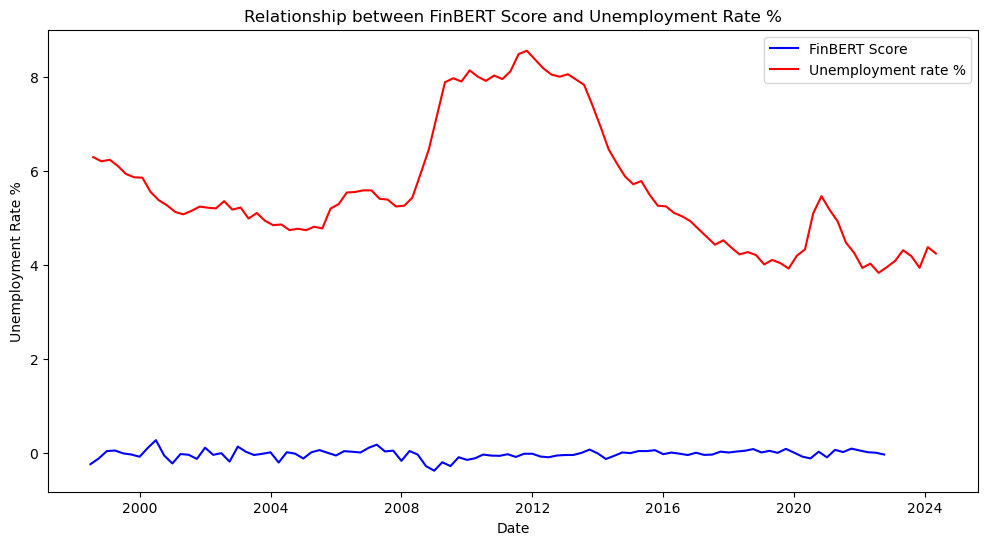

In [37]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot finbert_score in blue
plt.plot(quart_bert['quarter'], quart_bert['finbert_score'], color='blue', label='FinBERT Score')

# Plot Unemployment rate in red
plt.plot(quart_unemployment['quarter'], quart_unemployment['Unemployment rate %'], color='red', label='Unemployment rate %')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Unemployment Rate %')
plt.title('Relationship between FinBERT Score and Unemployment Rate %')

# Adding legend
plt.legend()

# Display the plot
plt.show()


**Note:** 
The plot is a bit hard to understand as they are both usnig the same y-axis. 
Try to add two different y-axis below for better readability.

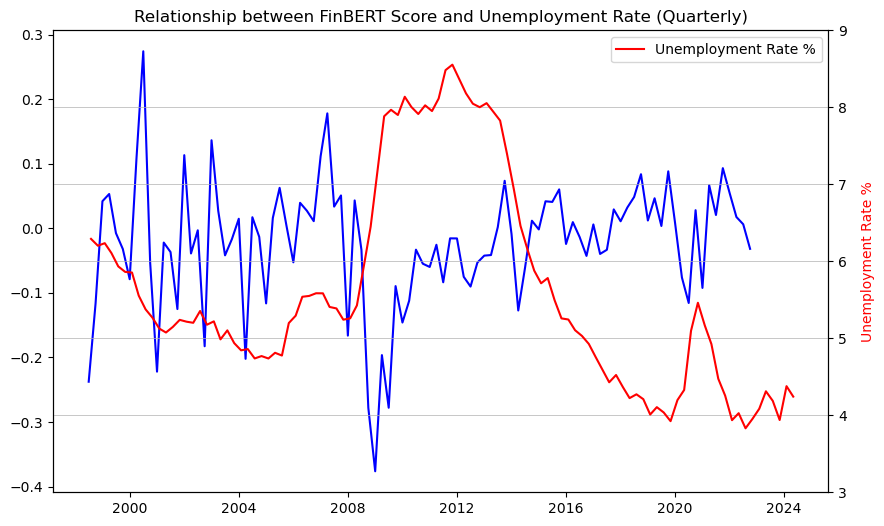

In [41]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot finbert_score in blue
plt.plot(quart_bert['quarter'], quart_bert['finbert_score'], color='blue', label='FinBERT Score', linestyle='-')  # Use dashed line for FinBERT score

# Set y-axis limits to (-1, 1) for better visualization
# plt.ylim(-1, 1)  # Set y-axis limits for FinBERT score

# Create a secondary y-axis for Unemployment rate
ax2 = plt.twinx()

# Plot Unemployment rate in red on the secondary y-axis
ax2.plot(quart_unemployment['quarter'], quart_unemployment['Unemployment rate %'], color='red', label='Unemployment Rate %')

# Set y-axis limits to (3, 9) for better visualization
ax2.set_ylim(3, 9)  # Set y-axis limits for Unemployment rate

# Adding labels and title
plt.xlabel('Time')

# Set labels for each y-axis with appropriate colors
# plt.ylabel('FinBERT Score', color='blue', labelpad=5)  # Primary y-axis label (blue) with padding
ax2.set_ylabel('Unemployment Rate %', color='red', labelpad=10)  # Secondary y-axis label (red) with padding

plt.title('Relationship between FinBERT Score and Unemployment Rate (Quarterly)')

# Adding legend
plt.legend()

# Customize x-axis intervals (adjust as needed based on your data)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Display the plot
plt.grid(True, which='both', linestyle='-', linewidth=0.5)  # Add grid lines

plt.show()


## FinBert Score & GBP/USD Exchange Rate

In [43]:
# View the DataFrame
print(quart_GBPUSD_after1998)


       quarter   GBP/USD
0   1998-07-01  1.699400
1   1998-10-01  1.663033
2   1999-01-01  1.619699
3   1999-04-01  1.596567
4   1999-07-01  1.624967
..         ...       ...
101 2023-10-01  1.251400
102 2024-01-01  1.267217
103 2024-04-01  1.263150
104 2024-07-01  1.313350
105 2024-10-01  1.299750

[106 rows x 2 columns]


### All Data Set (1998 - 2022)

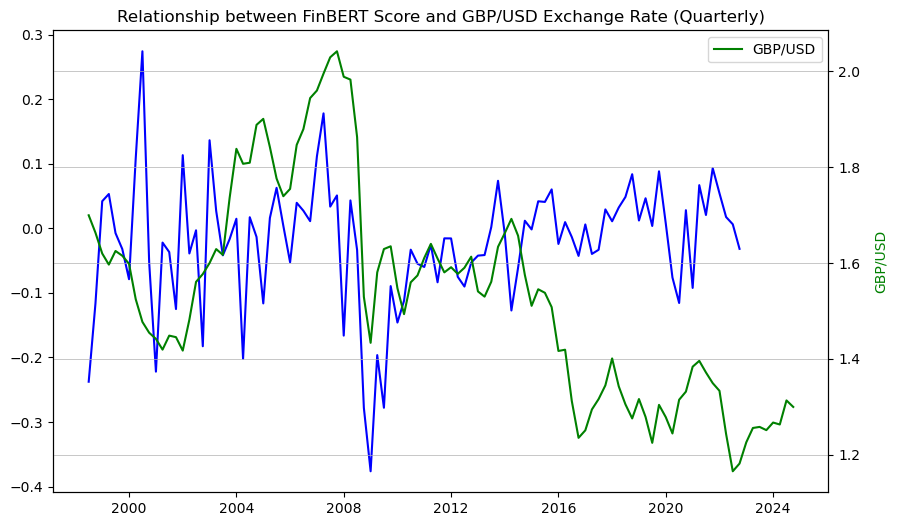

In [275]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot finbert_score in blue, set y-axis limits to (-1, 1) for better visualization
plt.plot(quart_bert['quarter'], quart_bert['finbert_score'], color='blue', label='FinBERT Score', linestyle='-')  # Use dashed line for FinBERT score
# plt.ylim(-1, 1)  # Set y-axis limits for FinBERT score

# Create a secondary y-axis for Unemployment rate
ax2 = plt.twinx()

# Plot Unemployment rate in red on the secondary y-axis, set y-axis limits to (1, 2.2) for better visualization
ax2.plot(quart_GBPUSD_after1998['quarter'], quart_GBPUSD_after1998['GBP/USD'], color='green', label='GBP/USD')
# ax2.set_ylim(1, 2.2)  # Set y-axis limits for Unemployment rate

# Adding labels and title
plt.xlabel('Time')

# Set labels for each y-axis with appropriate colors
plt.ylabel('FinBERT Score', color='blue', labelpad=10)  # Primary y-axis label (blue) with padding
ax2.set_ylabel('GBP/USD', color='green', labelpad=10)  # Secondary y-axis label (purple) with padding

plt.title('Relationship between FinBERT Score and GBP/USD Exchange Rate (Quarterly)')

# Adding legend
plt.legend()

# Customize x-axis intervals (adjust as needed based on your data)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Display the plot
plt.grid(True, which='both', linestyle='-', linewidth=0.5)  # Add grid lines

plt.show()

### Post-2008

In [ ]:
# Filter the data
# Sentiment Score
quart_bert_after2008 = quart_bert[quart_bert['quarter'] >= pd.to_datetime('2008-07-01')]

# GPB/USD Exchange
quart_GBPUSD_after2008 = quart_GBPUSD_after1998[quart_GBPUSD_after1998['quarter'] >= pd.to_datetime('2008-07-01')]


In [ ]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot finbert_score in blue, set y-axis limits to (-1, 1) for better visualization
plt.plot(quart_bert_after2008['quarter'], quart_bert_after2008['finbert_score'], color='blue', label='FinBERT Score', linestyle='-')  # Use dashed line for FinBERT score
# plt.ylim(-1, 1)  # Set y-axis limits for FinBERT score

# Create a secondary y-axis for Unemployment rate
ax2 = plt.twinx()

# Plot Unemployment rate in red on the secondary y-axis, set y-axis limits to (1, 2.2) for better visualization
ax2.plot(quart_GBPUSD_after2008['quarter'], quart_GBPUSD_after2008['GBP/USD'], color='green', label='GBP/USD')
# ax2.set_ylim(1, 2.2)  # Set y-axis limits for Unemployment rate

# Adding labels and title
plt.xlabel('Time')

# Set labels for each y-axis with appropriate colors
plt.ylabel('FinBERT Score', color='blue', labelpad=10)  # Primary y-axis label (blue) with padding
ax2.set_ylabel('GBP/USD', color='green', labelpad=10)  # Secondary y-axis label (purple) with padding

plt.title('Relationship between FinBERT Score and GBP/USD Exchange Rate after July 2008 (Quarterly)')

# Adding legend
plt.legend()

# Customize x-axis intervals (adjust as needed based on your data)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Display the plot
plt.grid(True, which='both', linestyle='-', linewidth=0.5)  # Add grid lines

plt.show()

## 2007 - 2010

In [281]:
# Filter the data
# Sentiment Score
quart_bert_07 = quart_bert[quart_bert['quarter'] >= pd.to_datetime('2007-01-01')]
quart_bert_0710 = quart_bert_07[quart_bert_07['quarter'] <= pd.to_datetime('2011-01-01')]

# GPB/USD Exchange
quart_GBPUSD_after2007 = quart_GBPUSD_after1998[quart_GBPUSD_after1998['quarter'] >= pd.to_datetime('2007-01-01')]
quart_GBPUSD_0710 = quart_GBPUSD_after2007[quart_GBPUSD_after2007['quarter'] <= pd.to_datetime('2011-01-01')]


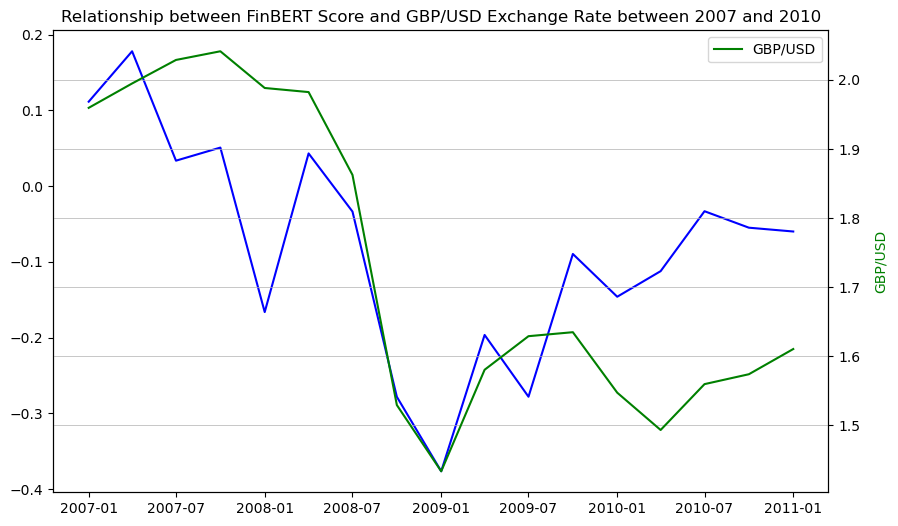

In [283]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot finbert_score in blue, set y-axis limits to (-1, 1) for better visualization
plt.plot(quart_bert_0710['quarter'], quart_bert_0710['finbert_score'], color='blue', label='FinBERT Score', linestyle='-')  # Use dashed line for FinBERT score
# plt.ylim(-1, 1)  # Set y-axis limits for FinBERT score

# Create a secondary y-axis for Unemployment rate
ax2 = plt.twinx()

# Plot Unemployment rate in red on the secondary y-axis, set y-axis limits to (1, 2.2) for better visualization
ax2.plot(quart_GBPUSD_0710['quarter'], quart_GBPUSD_0710['GBP/USD'], color='green', label='GBP/USD')
# ax2.set_ylim(1, 2.2)  # Set y-axis limits for Unemployment rate

# Adding labels and title
plt.xlabel('Time')

# Set labels for each y-axis with appropriate colors
plt.ylabel('FinBERT Score', color='blue', labelpad=10)  # Primary y-axis label (blue) with padding
ax2.set_ylabel('GBP/USD', color='green', labelpad=10)  # Secondary y-axis label (purple) with padding

plt.title('Relationship between FinBERT Score and GBP/USD Exchange Rate between 2007 and 2010')

# Adding legend
plt.legend()

# Customize x-axis intervals (adjust as needed based on your data)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Display the plot
plt.grid(True, which='both', linestyle='-', linewidth=0.5)  # Add grid lines

plt.show()

# 4. Correlation Analysis

## Prepare Data

### FinBert Score

In [49]:
# Create quarterly average DataFrame (FinBert)
quart_bert1 = bert_sentiment_uk.groupby('quarter')['finbert_score'].mean().reset_index()

# Ensure that 'quarter' is in a Period format if it's not already
if quart_bert1['quarter'].dtype != 'period[Q]':
    quart_bert1['quarter'] = pd.PeriodIndex(quart_bert1['quarter'], freq='Q')

# View the DataFrame
quart_bert1.head()


,quarter,finbert_score
0,1998Q3,-0.237672
1,1998Q4,-0.116431
2,1999Q1,0.041918
3,1999Q2,0.053082
4,1999Q3,-0.007517


Unemployment Rate

In [51]:
# Create quarterly average DataFrame (FinBert)
quart_unemployment_1 = quart_unemployment.groupby('quarter')['Unemployment rate %'].mean().reset_index()

# Ensure that 'quarter' is in a Period format if it's not already
if quart_unemployment_1['quarter'].dtype != 'period[Q]':
    quart_unemployment_1['quarter'] = pd.PeriodIndex(quart_unemployment_1['quarter'], freq='Q')

# View the DataFrame
quart_unemployment_1.head()


,quarter,Unemployment rate %
0,1998Q3,6.290870
1,1998Q4,6.202054
2,1999Q1,6.235015
3,1999Q2,6.107371
4,1999Q3,5.933357


### GBP/USD Exchange Rate

In [53]:
# Create quarterly average DataFrame (FinBert)
quart_GBPUSD_1 = quart_GBPUSD_after1998.groupby('quarter')['GBP/USD'].mean().reset_index()

# Ensure that 'quarter' is in a Period format if it's not already
if quart_GBPUSD_1['quarter'].dtype != 'period[Q]':
    quart_GBPUSD_1['quarter'] = pd.PeriodIndex(quart_GBPUSD_1['quarter'], freq='Q')

# View the DataFrame
quart_GBPUSD_1.head()


,quarter,GBP/USD
0,1998Q3,1.699400
1,1998Q4,1.663033
2,1999Q1,1.619699
3,1999Q2,1.596567
4,1999Q3,1.624967


### FinBert Score, unemployment rate & GBP/USD exchange rate

In [229]:
# Join the DataFrame (unemployment rate and GBP/USD exchange rate)
Unemployment_GBPUSD = pd.merge(quart_unemployment_1,quart_GBPUSD_1,on ='quarter',how= 'inner')

# Join the DataFrame (FinBert Score + unemployment rate and GBP/USD exchange rate)
FinBert_Unemployment_GBPUSD = pd.merge(Unemployment_GBPUSD,quart_bert1,on ='quarter',how= 'inner')

# # View the merged DataFrame
FinBert_Unemployment_GBPUSD.head()


,quarter,Unemployment rate %,GBP/USD,finbert_score
0,1998Q3,6.290870,1.699400,-0.237672
1,1998Q4,6.202054,1.663033,-0.116431
2,1999Q1,6.235015,1.619699,0.041918
3,1999Q2,6.107371,1.596567,0.053082
4,1999Q3,5.933357,1.624967,-0.007517


In [231]:
# Calculate the correlation matrix
FinBert_Unemployment_GBPUSD_corr = FinBert_Unemployment_GBPUSD[['Unemployment rate %','GBP/USD','finbert_score']].corr()

# Display the correlation matrix 
FinBert_Unemployment_GBPUSD_corr 


,Unemployment rate %,GBP/USD,finbert_score
Unemployment rate %,1.000000,0.283716,-0.357440
GBP/USD,0.283716,1.000000,-0.017768
finbert_score,-0.357440,-0.017768,1.000000


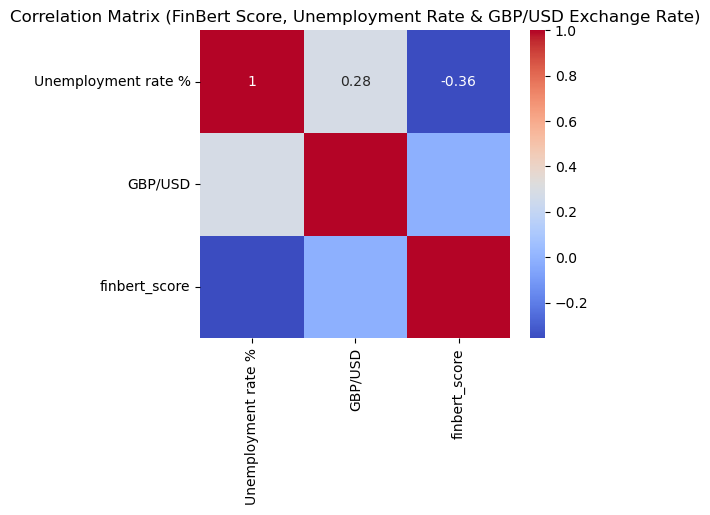

In [237]:
# Create a correlation matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(FinBert_Unemployment_GBPUSD_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (FinBert Score, Unemployment Rate & GBP/USD Exchange Rate)')
plt.show()


### Compute the p-value for the correlation coefficient

In [233]:
# View the relevant DataFrame
print(FinBert_Unemployment_GBPUSD.shape)
FinBert_Unemployment_GBPUSD.head()


(98, 4)


,quarter,Unemployment rate %,GBP/USD,finbert_score
0,1998Q3,6.290870,1.699400,-0.237672
1,1998Q4,6.202054,1.663033,-0.116431
2,1999Q1,6.235015,1.619699,0.041918
3,1999Q2,6.107371,1.596567,0.053082
4,1999Q3,5.933357,1.624967,-0.007517


In [235]:
from scipy.stats import pearsonr

# Assuming you have the following columns in your DataFrame `df`:
# - 'finbert_score' for FinBert sentiment scores
# - 'unemployment_rate' for the unemployment rate
# - 'exchange_rate' for GBP/USD exchange rate

# Calculate correlation and p-value between FinBert sentiment and unemployment rate
corr_unemployment, p_value_unemployment = pearsonr(FinBert_Unemployment_GBPUSD['finbert_score'], FinBert_Unemployment_GBPUSD['Unemployment rate %'])

# Calculate correlation and p-value between FinBert sentiment and GBP/USD exchange rate
corr_exchange_rate, p_value_exchange_rate = pearsonr(FinBert_Unemployment_GBPUSD['finbert_score'], FinBert_Unemployment_GBPUSD['GBP/USD'])

# Calculate correlation and p-value between Unemployment rate and GBP/USD exchange rate
corr_labour_currency_rate, p_value_labour_currency_rate = pearsonr(FinBert_Unemployment_GBPUSD['Unemployment rate %'], FinBert_Unemployment_GBPUSD['GBP/USD'])

# Display results
print("Correlation, P-value & Significance Test Results")
print("\nCorrelation between FinBert sentiment and Unemployment Rate:", corr_unemployment)
print("P-value:", p_value_unemployment)
print("\nCorrelation between FinBert sentiment and GBP/USD Exchange Rate:", corr_exchange_rate)
print("P-value:", p_value_exchange_rate)
print("\nCorrelation between FinBert sentiment and GBP/USD Exchange Rate:", corr_labour_currency_rate)
print("P-value:", p_value_labour_currency_rate)

# Check significance
alpha = 0.05  # Common threshold for significance (5%)
if p_value_unemployment < alpha:
    print("\nThe correlation between FinBert sentiment score and Unemployment Rate is statistically significant.")
else:
    print("\nThe correlation between FinBert sentiment score and Unemployment Rate is NOT statistically significant.")

if p_value_exchange_rate < alpha:
    print("\nThe correlation between FinBert sentiment score and GBP/USD Exchange Rate is statistically significant.")
else:
    print("\nThe correlation between FinBert sentiment score and GBP/USD Exchange Rate is NOT statistically significant.")

if p_value_labour_currency_rate < alpha:
    print("\nThe correlation between Unemployment Rate and GBP/USD Exchange Rate is statistically significant.")
else:
    print("\nThe correlation between Unemployment Rate and GBP/USD Exchange Rate is NOT statistically significant.")


Correlation, P-value & Significance Test Results

Correlation between FinBert sentiment and Unemployment Rate: -0.3574399603470626
P-value: 0.00030243066908223825

Correlation between FinBert sentiment and GBP/USD Exchange Rate: -0.017768371145480813
P-value: 0.862136825074537

Correlation between FinBert sentiment and GBP/USD Exchange Rate: 0.2837156105119451
P-value: 0.004639923959807956

The correlation between FinBert sentiment score and Unemployment Rate is statistically significant.

The correlation between FinBert sentiment score and GBP/USD Exchange Rate is NOT statistically significant.

The correlation between Unemployment Rate and GBP/USD Exchange Rate is statistically significant.


# 5. Deeper Analysis

## Focus on after 2008 (2008 till the end)

In [239]:
# Convert the 'quarter' column from PeriodDtype to datetime
FinBert_Unemployment_GBPUSD['quarter'] = FinBert_Unemployment_GBPUSD['quarter'].dt.to_timestamp()

# Filter data after 2008 Q2
FinBert_Unemployment_GBPUSD_2008 = FinBert_Unemployment_GBPUSD[FinBert_Unemployment_GBPUSD['quarter'] >= pd.to_datetime('2008-07-01')]

# Reset index
FinBert_Unemployment_GBPUSD_2008 = FinBert_Unemployment_GBPUSD_2008.reset_index(drop=True)

# View the new DataFrame
print(FinBert_Unemployment_GBPUSD_2008.shape)
FinBert_Unemployment_GBPUSD_2008.head()


(58, 4)


,quarter,Unemployment rate %,GBP/USD,finbert_score
0,2008-07-01,5.931771,1.862433,-0.033596
1,2008-10-01,6.448675,1.529317,-0.278111
2,2009-01-01,7.175976,1.433467,-0.376372
3,2009-04-01,7.883244,1.580400,-0.196440
4,2009-07-01,7.967259,1.629000,-0.277979


In [109]:
# Calculate the correlation matrix
FinBert_Unemployment_GBPUSD_2008_corr = FinBert_Unemployment_GBPUSD_2008[['Unemployment rate %','GBP/USD','finbert_score']].corr()

# Display the correlation matrix 
FinBert_Unemployment_GBPUSD_2008_corr


,Unemployment rate %,GBP/USD,finbert_score
Unemployment rate %,1.000000,0.802048,-0.491131
GBP/USD,0.802048,1.000000,-0.312516
finbert_score,-0.491131,-0.312516,1.000000


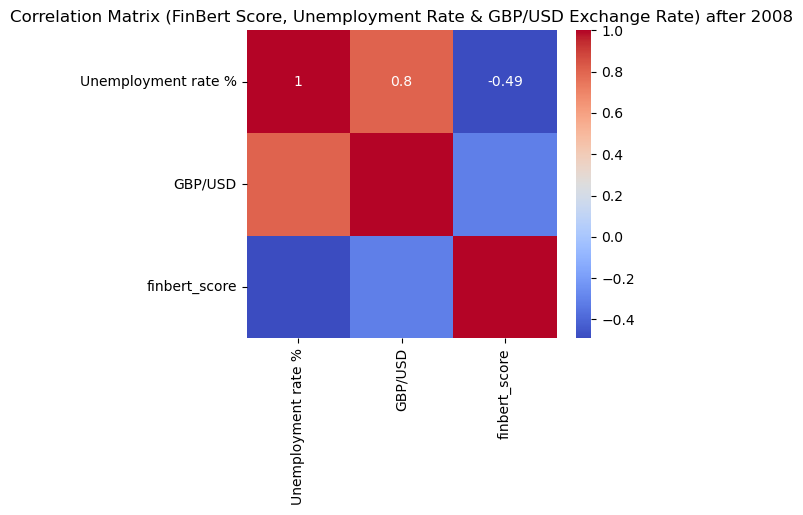

In [111]:
# Create a correlation matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(FinBert_Unemployment_GBPUSD_2008_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (FinBert Score, Unemployment Rate & GBP/USD Exchange Rate) after 2008')
plt.show()


In [279]:
# Calculate correlation and p-value between FinBert sentiment and unemployment rate
corr_unemployment_2008, p_value_unemployment_2008 = pearsonr(FinBert_Unemployment_GBPUSD_2008['finbert_score'], FinBert_Unemployment_GBPUSD_2008['Unemployment rate %'])

# Calculate correlation and p-value between FinBert sentiment and GBP/USD exchange rate
corr_exchange_rate_2008, p_value_exchange_rate_2008 = pearsonr(FinBert_Unemployment_GBPUSD_2008['finbert_score'], FinBert_Unemployment_GBPUSD_2008['GBP/USD'])

# Calculate correlation and p-value between Unemployment rate and GBP/USD exchange rate
corr_labour_currency_rate_2008, p_value_labour_currency_rate_2008 = pearsonr(FinBert_Unemployment_GBPUSD_2008['Unemployment rate %'], FinBert_Unemployment_GBPUSD_2008['GBP/USD'])

# Display results
print("Correlation, P-value & Significance Test Results")
print("\nCorrelation between FinBert sentiment and Unemployment Rate:", corr_unemployment_2008)
print("P-value:", p_value_unemployment_2008)
print("\nCorrelation between FinBert sentiment and GBP/USD Exchange Rate:", corr_exchange_rate_2008)
print("P-value:", p_value_exchange_rate_2008)
print("\nCorrelation between FinBert sentiment and GBP/USD Exchange Rate:", corr_labour_currency_rate_2008)
print("P-value:", p_value_labour_currency_rate_2008)

# Check significance
alpha = 0.05  # Common threshold for significance (5%)
if p_value_unemployment_2008 < alpha:
    print("\nThe correlation between FinBert sentiment score and Unemployment Rate is statistically significant.")
else:
    print("\nThe correlation between FinBert sentiment score and Unemployment Rate is NOT statistically significant.")

if p_value_exchange_rate_2008 < alpha:
    print("\nThe correlation between FinBert sentiment score and GBP/USD Exchange Rate is statistically significant.")
else:
    print("\nThe correlation between FinBert sentiment score and GBP/USD Exchange Rate is NOT statistically significant.")

if p_value_labour_currency_rate_2008 < alpha:
    print("\nThe correlation between Unemployment Rate and GBP/USD Exchange Rate is statistically significant.")
else:
    print("\nThe correlation between Unemployment Rate and GBP/USD Exchange Rate is NOT statistically significant.")

Correlation, P-value & Significance Test Results

Correlation between FinBert sentiment and Unemployment Rate: -0.4911312311292758
P-value: 9.058447283505031e-05

Correlation between FinBert sentiment and GBP/USD Exchange Rate: -0.31251609436124383
P-value: 0.016921905696593943

Correlation between FinBert sentiment and GBP/USD Exchange Rate: 0.8020484058922748
P-value: 3.826120532293431e-14

The correlation between FinBert sentiment score and Unemployment Rate is statistically significant.

The correlation between FinBert sentiment score and GBP/USD Exchange Rate is statistically significant.

The correlation between Unemployment Rate and GBP/USD Exchange Rate is statistically significant.


## Focus on period between 2007 and 2010

In [388]:
# Convert the 'quarter' column from PeriodDtype to datetime
# FinBert_Unemployment_GBPUSD['quarter'] = FinBert_Unemployment_GBPUSD['quarter'].dt.to_datetime()

# Filter data between 2007 and 2010
FinBert_Unemployment_GBPUSD_07 = FinBert_Unemployment_GBPUSD[FinBert_Unemployment_GBPUSD['quarter'] >= pd.to_datetime('2007-01-01')]
FinBert_Unemployment_GBPUSD_0710 = FinBert_Unemployment_GBPUSD_07[FinBert_Unemployment_GBPUSD_07['quarter'] < pd.to_datetime('2011-01-01')]

# Reset index
FinBert_Unemployment_GBPUSD_0710 = FinBert_Unemployment_GBPUSD_0710.reset_index(drop=True)

# View the new DataFrame
print(FinBert_Unemployment_GBPUSD_0710.shape)
FinBert_Unemployment_GBPUSD_0710.head()

(16, 4)


,quarter,Unemployment_rate,GBP/USD,finbert_score
0,2007-01-01,5.583737,1.959500,0.111425
1,2007-04-01,5.406897,1.994767,0.177961
2,2007-07-01,5.387540,2.028817,0.033574
3,2007-10-01,5.241494,2.041367,0.050853
4,2008-01-01,5.258797,1.988233,-0.166240


In [390]:
# Calculate the correlation matrix
FinBert_Unemployment_GBPUSD_0710_corr = FinBert_Unemployment_GBPUSD_0710[['Unemployment_rate','GBP/USD','finbert_score']].corr()

# Display the correlation matrix 
FinBert_Unemployment_GBPUSD_0710_corr


,Unemployment_rate,GBP/USD,finbert_score
Unemployment_rate,1.000000,-0.894288,-0.531520
GBP/USD,-0.894288,1.000000,0.730125
finbert_score,-0.531520,0.730125,1.000000


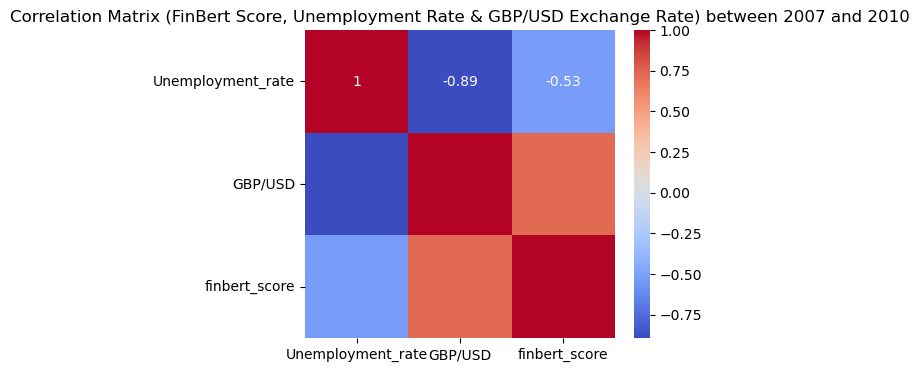

In [392]:
# Create a correlation matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(FinBert_Unemployment_GBPUSD_0710_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (FinBert Score, Unemployment Rate & GBP/USD Exchange Rate) between 2007 and 2010')
plt.show()


In [394]:
# Rename the column to avoid special characters
FinBert_Unemployment_GBPUSD_0710 = FinBert_Unemployment_GBPUSD_0710.rename(columns={'GBP/USD': 'GBP_USD'})

# Calculate correlation and p-value between FinBert sentiment and unemployment rate
corr_unemployment_0710, p_value_unemployment_0710 = pearsonr(FinBert_Unemployment_GBPUSD_0710['finbert_score'], FinBert_Unemployment_GBPUSD_0710['Unemployment_rate'])

# Calculate correlation and p-value between FinBert sentiment and GBP/USD exchange rate
corr_exchange_rate_0710, p_value_exchange_rate_0710 = pearsonr(FinBert_Unemployment_GBPUSD_0710['finbert_score'], FinBert_Unemployment_GBPUSD_0710['GBP_USD'])

# Calculate correlation and p-value between Unemployment rate and GBP/USD exchange rate
corr_labour_currency_rate_0710, p_value_labour_currency_rate_0710 = pearsonr(FinBert_Unemployment_GBPUSD_0710['Unemployment_rate'], FinBert_Unemployment_GBPUSD_0710['GBP_USD'])

# Display results
print("Correlation, P-value & Significance Test Results")
print("\nCorrelation between FinBert sentiment and Unemployment Rate:", corr_unemployment_0710)
print("P-value:", p_value_unemployment_0710)
print("\nCorrelation between FinBert sentiment and GBP/USD Exchange Rate:", corr_exchange_rate_0710)
print("P-value:", p_value_exchange_rate_0710)
print("\nCorrelation between Unemployment and GBP/USD Exchange Rate:", corr_labour_currency_rate_0710)
print("P-value:", p_value_labour_currency_rate_0710)

# Check significance
alpha = 0.05  # Common threshold for significance (5%)
if p_value_unemployment_0710 < alpha:
    print("\nThe correlation between FinBert sentiment score and Unemployment Rate is statistically significant between 2007 and 2010.")
else:
    print("\nThe correlation between FinBert sentiment score and Unemployment Rate is NOT statistically significant between 2007 and 2010.")

if p_value_exchange_rate_0710 < alpha:
    print("\nThe correlation between FinBert sentiment score and GBP/USD Exchange Rate is statistically significant between 2007 and 2010.")
else:
    print("\nThe correlation between FinBert sentiment score and GBP/USD Exchange Rate is NOT statistically significant between 2007 and 2010.")

if p_value_labour_currency_rate_0710 < alpha:
    print("\nThe correlation between Unemployment Rate and GBP/USD Exchange Rate is statistically significant between 2007 and 2010.")
else:
    print("\nThe correlation between Unemployment Rate and GBP/USD Exchange Rate is NOT statistically significant between 2007 and 2010.")
    

Correlation, P-value & Significance Test Results

Correlation between FinBert sentiment and Unemployment Rate: -0.5315201886173342
P-value: 0.03410055177637025

Correlation between FinBert sentiment and GBP/USD Exchange Rate: 0.7301254825146741
P-value: 0.0013212449944389637

Correlation between Unemployment and GBP/USD Exchange Rate: -0.8942879938118236
P-value: 2.978951020510478e-06

The correlation between FinBert sentiment score and Unemployment Rate is statistically significant between 2007 and 2010.

The correlation between FinBert sentiment score and GBP/USD Exchange Rate is statistically significant between 2007 and 2010.

The correlation between Unemployment Rate and GBP/USD Exchange Rate is statistically significant between 2007 and 2010.


## Focus on Brexit Period (2015 - 2016)

In [115]:
# Convert the 'quarter' column from PeriodDtype to datetime
# FinBert_Unemployment_GBPUSD['quarter'] = FinBert_Unemployment_GBPUSD['quarter'].dt.to_timestamp()

# Filter data between 2015 and 2016
FinBert_Unemployment_GBPUSD_Brexit = FinBert_Unemployment_GBPUSD[FinBert_Unemployment_GBPUSD['quarter'] >= pd.to_datetime('2015-01-01')]
FinBert_Unemployment_GBPUSD_Brexit = FinBert_Unemployment_GBPUSD_Brexit[FinBert_Unemployment_GBPUSD_Brexit['quarter'] <= pd.to_datetime('2016-12-01')]

# Reset index
FinBert_Unemployment_GBPUSD_Brexit = FinBert_Unemployment_GBPUSD_Brexit.reset_index(drop=True)

# View the new DataFrame
print(FinBert_Unemployment_GBPUSD_Brexit.shape)
FinBert_Unemployment_GBPUSD_Brexit.head()


(8, 4)


,quarter,Unemployment rate %,GBP/USD,finbert_score
0,2015-01-01,5.714197,1.510600,-0.001792
1,2015-04-01,5.782048,1.545133,0.041796
2,2015-07-01,5.493901,1.537750,0.040817
3,2015-10-01,5.258135,1.507867,0.060227
4,2016-01-01,5.243785,1.416467,-0.024295


In [293]:
# Calculate the correlation matrix
FinBert_Unemployment_GBPUSD_Brexit_corr = FinBert_Unemployment_GBPUSD_Brexit[['Unemployment rate %','GBP/USD','finbert_score']].corr()

# Display the correlation matrix 
FinBert_Unemployment_GBPUSD_Brexit_corr


,Unemployment rate %,GBP/USD,finbert_score
Unemployment rate %,1.000000,0.855943,0.535170
GBP/USD,0.855943,1.000000,0.823922
finbert_score,0.535170,0.823922,1.000000


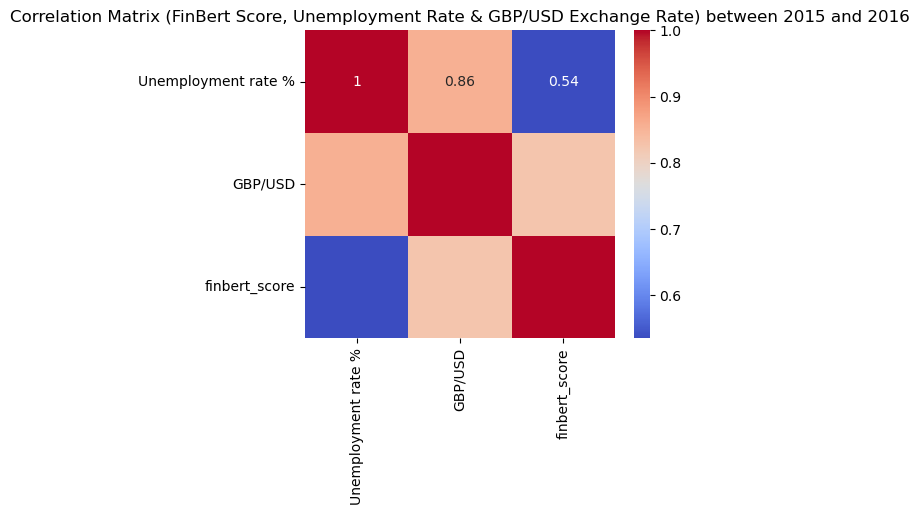

In [295]:
# Create a correlation matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(FinBert_Unemployment_GBPUSD_Brexit_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (FinBert Score, Unemployment Rate & GBP/USD Exchange Rate) between 2015 and 2016')
plt.show()


In [117]:
# Calculate correlation and p-value between FinBert sentiment and unemployment rate
corr_unemployment_Brexit, p_value_unemployment_Brexit = pearsonr(FinBert_Unemployment_GBPUSD_Brexit['finbert_score'], FinBert_Unemployment_GBPUSD_Brexit['Unemployment rate %'])

# Calculate correlation and p-value between FinBert sentiment and GBP/USD exchange rate
corr_exchange_rate_Brexit, p_value_exchange_rate_Brexit = pearsonr(FinBert_Unemployment_GBPUSD_Brexit['finbert_score'], FinBert_Unemployment_GBPUSD_Brexit['GBP/USD'])

# Calculate correlation and p-value between Unemployment rate and GBP/USD exchange rate
corr_labour_currency_rate_Brexit, p_value_labour_currency_rate_Brexit = pearsonr(FinBert_Unemployment_GBPUSD_Brexit['Unemployment rate %'], FinBert_Unemployment_GBPUSD_Brexit['GBP/USD'])

# Display results
print("Correlation, P-value & Significance Test Results")
print("\nCorrelation between FinBert sentiment and Unemployment Rate:", corr_unemployment_Brexit)
print("P-value:", p_value_unemployment_Brexit)
print("\nCorrelation between FinBert sentiment and GBP/USD Exchange Rate:", corr_exchange_rate_Brexit)
print("P-value:", p_value_exchange_rate_Brexit)
print("\nCorrelation between FinBert sentiment and GBP/USD Exchange Rate:", corr_labour_currency_rate_Brexit)
print("P-value:", p_value_labour_currency_rate_Brexit)

# Check significance
alpha = 0.05  # Common threshold for significance (5%)
if p_value_unemployment_Brexit < alpha:
    print("\nThe correlation between FinBert sentiment score and Unemployment Rate is statistically significant during Brexit.")
else:
    print("\nThe correlation between FinBert sentiment score and Unemployment Rate is NOT statistically significant during Brexit.")

if p_value_exchange_rate_Brexit < alpha:
    print("\nThe correlation between FinBert sentiment score and GBP/USD Exchange Rate is statistically significant during Brexit.")
else:
    print("\nThe correlation between FinBert sentiment score and GBP/USD Exchange Rate is NOT statistically significant during Brexit.")

if p_value_labour_currency_rate_Brexit < alpha:
    print("\nThe correlation between Unemployment Rate and GBP/USD Exchange Rate is statistically significant during Brexit.")
else:
    print("\nThe correlation between Unemployment Rate and GBP/USD Exchange Rate is NOT statistically significant during Brexit.")


Correlation, P-value & Significance Test Results

Correlation between FinBert sentiment and Unemployment Rate: 0.5351696048928214
P-value: 0.17168983920505276

Correlation between FinBert sentiment and GBP/USD Exchange Rate: 0.8239219197827519
P-value: 0.01190877529835715

Correlation between FinBert sentiment and GBP/USD Exchange Rate: 0.8559434795785057
P-value: 0.006689535928065405

The correlation between FinBert sentiment score and Unemployment Rate is NOT statistically significant during Brexit.

The correlation between FinBert sentiment score and GBP/USD Exchange Rate is statistically significant during Brexit.

The correlation between Unemployment Rate and GBP/USD Exchange Rate is statistically significant during Brexit.


## Focus on Covid Period (2020 till the end) (NOT Significant)

In [305]:
# Convert the 'quarter' column from PeriodDtype to datetime
# FinBert_Unemployment_GBPUSD['quarter'] = FinBert_Unemployment_GBPUSD['quarter'].dt.to_timestamp()

# Filter data between 2015 and 2016
FinBert_Unemployment_GBPUSD_Covid = FinBert_Unemployment_GBPUSD[FinBert_Unemployment_GBPUSD['quarter'] >= pd.to_datetime('2020-01-01')]

# Reset index
FinBert_Unemployment_GBPUSD_Covid = FinBert_Unemployment_GBPUSD_Covid.reset_index(drop=True)

# View the new DataFrame
FinBert_Unemployment_GBPUSD_Covid.head()


,quarter,Unemployment rate %,GBP/USD,finbert_score
0,2020-01-01,4.196995,1.278483,0.007548
1,2020-04-01,4.328861,1.244417,-0.076263
2,2020-07-01,5.097394,1.314750,-0.115676
3,2020-10-01,5.461065,1.331667,0.028016
4,2021-01-01,5.167557,1.383667,-0.092368


In [307]:
# Calculate the correlation matrix
FinBert_Unemployment_GBPUSD_Covid_corr = FinBert_Unemployment_GBPUSD_Covid[['Unemployment rate %','GBP/USD','finbert_score']].corr()

# Display the correlation matrix 
FinBert_Unemployment_GBPUSD_Covid_corr


,Unemployment rate %,GBP/USD,finbert_score
Unemployment rate %,1.000000,0.642579,-0.289008
GBP/USD,0.642579,1.000000,0.214113
finbert_score,-0.289008,0.214113,1.000000


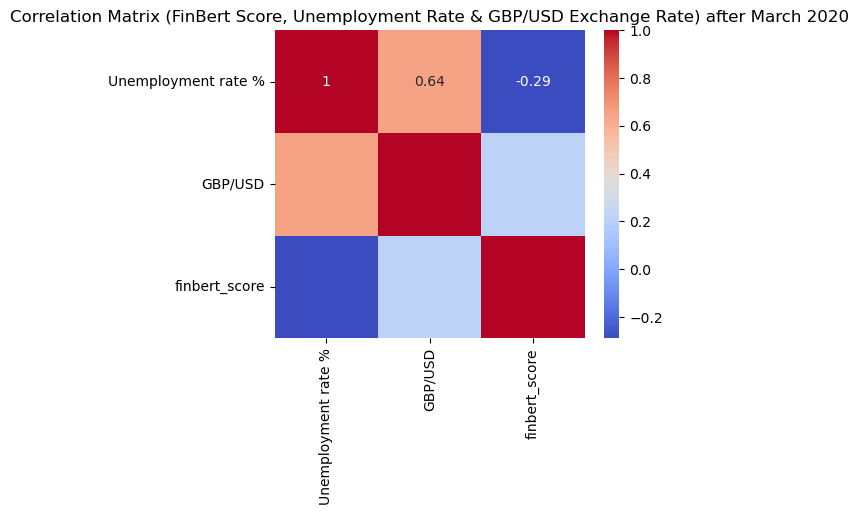

In [309]:
# Create a correlation matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(FinBert_Unemployment_GBPUSD_Covid_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (FinBert Score, Unemployment Rate & GBP/USD Exchange Rate) after March 2020')
plt.show()


In [ ]:
# Calculate correlation and p-value between FinBert sentiment and unemployment rate
corr_unemployment_Covid, p_value_unemployment_Covid = pearsonr(FinBert_Unemployment_GBPUSD_Covid['finbert_score'], FinBert_Unemployment_GBPUSD_Covid['Unemployment rate %'])

# Calculate correlation and p-value between FinBert sentiment and GBP/USD exchange rate
corr_exchange_rate_Covid, p_value_exchange_rate_Covid = pearsonr(FinBert_Unemployment_GBPUSD_Covid['finbert_score'], FinBert_Unemployment_GBPUSD_Covid['GBP/USD'])

# Calculate correlation and p-value between Unemployment rate and GBP/USD exchange rate
corr_labour_currency_rate_Covid, p_value_labour_currency_rate_Covid = pearsonr(FinBert_Unemployment_GBPUSD_Covid['Unemployment rate %'], FinBert_Unemployment_GBPUSD_Covid['GBP/USD'])

# Display results
print("Correlation, P-value & Significance Test Results")
print("\nCorrelation between FinBert sentiment and Unemployment Rate:", corr_unemployment_Covid)
print("P-value:", p_value_unemployment_Covid)
print("\nCorrelation between FinBert sentiment and GBP/USD Exchange Rate:", corr_exchange_rate_Covid)
print("P-value:", p_value_exchange_rate_Covid)
print("\nCorrelation between FinBert sentiment and GBP/USD Exchange Rate:", corr_labour_currency_rate_Covid)
print("P-value:", p_value_labour_currency_rate_Covid)

# Check significance
alpha = 0.05  # Common threshold for significance (5%)
if p_value_unemployment_Covid < alpha:
    print("\nThe correlation between FinBert sentiment score and Unemployment Rate is statistically significant during Covid.")
else:
    print("\nThe correlation between FinBert sentiment score and Unemployment Rate is NOT statistically significant during Covid.")

if p_value_exchange_rate_Covid < alpha:
    print("\nThe correlation between FinBert sentiment score and GBP/USD Exchange Rate is statistically significant during Covid.")
else:
    print("\nThe correlation between FinBert sentiment score and GBP/USD Exchange Rate is NOT statistically significant during Covid.")

if p_value_labour_currency_rate_Covid < alpha:
    print("\nThe correlation between Unemployment Rate and GBP/USD Exchange Rate is statistically significant during Covid.")
else:
    print("\nThe correlation between Unemployment Rate and GBP/USD Exchange Rate is NOT statistically significant during Covid.")

## Focus 2018 - 2022

In [357]:
# Create a new DataFrame
FinBert_Unemployment_GBPUSD_1822 = FinBert_Unemployment_GBPUSD[FinBert_Unemployment_GBPUSD['quarter'] >= pd.to_datetime('2018-01-01')]

# Reset index
FinBert_Unemployment_GBPUSD_1822 = FinBert_Unemployment_GBPUSD_1822.reset_index(drop=True)

# View the new DataFrame
print(FinBert_Unemployment_GBPUSD_1822.shape)
FinBert_Unemployment_GBPUSD_1822.head()


(20, 4)


,quarter,Unemployment_rate,GBP/USD,finbert_score
0,2018-01-01,4.365093,1.400900,0.010852
1,2018-04-01,4.223013,1.342750,0.032147
2,2018-07-01,4.272323,1.305183,0.048493
3,2018-10-01,4.209048,1.275750,0.083752
4,2019-01-01,4.009654,1.316200,0.012018


In [369]:
# Calculate the correlation matrix
FinBert_Unemployment_GBPUSD_1822_corr = FinBert_Unemployment_GBPUSD_1822[['Unemployment_rate','GBP/USD','finbert_score']].corr()

# Display the correlation matrix 
FinBert_Unemployment_GBPUSD_1822_corr


,Unemployment_rate,GBP/USD,finbert_score
Unemployment_rate,1.000000,0.551144,-0.373369
GBP/USD,0.551144,1.000000,0.153612
finbert_score,-0.373369,0.153612,1.000000


In [ ]:
# Create a correlation matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(FinBert_Unemployment_GBPUSD_1822_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (FinBert Score, Unemployment Rate & GBP/USD Exchange Rate) after March 2020')
plt.show()

In [379]:
# Calculate correlation and p-value between FinBert sentiment and unemployment rate
corr_unemployment_1822, p_value_unemployment_1822 = pearsonr(FinBert_Unemployment_GBPUSD_1822['finbert_score'], FinBert_Unemployment_GBPUSD_1822['Unemployment_rate'])

# Calculate correlation and p-value between FinBert sentiment and GBP/USD exchange rate
corr_exchange_rate_1822, p_value_exchange_rate_1822 = pearsonr(FinBert_Unemployment_GBPUSD_1822['finbert_score'], FinBert_Unemployment_GBPUSD_1822['GBP/USD'])

# Calculate correlation and p-value between Unemployment rate and GBP/USD exchange rate
corr_labour_currency_rate_1822, p_value_labour_currency_rate_1822 = pearsonr(FinBert_Unemployment_GBPUSD_1822['Unemployment_rate'], FinBert_Unemployment_GBPUSD_1822['GBP/USD'])

# Display results
print("Correlation, P-value & Significance Test Results")
print("\nCorrelation between FinBert sentiment and Unemployment Rate:", corr_unemployment_1822)
print("P-value:", p_value_unemployment_1822)
print("\nCorrelation between FinBert sentiment and GBP/USD Exchange Rate:", corr_exchange_rate_1822)
print("P-value:", p_value_exchange_rate_1822)
print("\nCorrelation between Unemployment and GBP/USD Exchange Rate:", corr_labour_currency_rate_1822)
print("P-value:", p_value_labour_currency_rate_1822)

# Check significance
alpha = 0.05  # Common threshold for significance (5%)
if p_value_unemployment_1822 < alpha:
    print("\nThe correlation between FinBert sentiment score and Unemployment Rate is statistically significant between 2018 and 2022.")
else:
    print("\nThe correlation between FinBert sentiment score and Unemployment Rate is NOT statistically significant between 2018 and 2022.")

if p_value_exchange_rate_1822 < alpha:
    print("\nThe correlation between FinBert sentiment score and GBP/USD Exchange Rate is statistically significant between 2018 and 2022.")
else:
    print("\nThe correlation between FinBert sentiment score and GBP/USD Exchange Rate is NOT statistically significant between 2018 and 2022.")

if p_value_labour_currency_rate_1822 < alpha:
    print("\nThe correlation between Unemployment Rate and GBP/USD Exchange Rate is statistically significant between 2018 and 2022.")
else:
    print("\nThe correlation between Unemployment Rate and GBP/USD Exchange Rate is NOT statistically significant between 2018 and 2022.")
    

Correlation, P-value & Significance Test Results

Correlation between FinBert sentiment and Unemployment Rate: -0.37336852584529634
P-value: 0.10490890952181883

Correlation between FinBert sentiment and GBP/USD Exchange Rate: 0.15361193800673872
P-value: 0.5178941452249113

Correlation between Unemployment and GBP/USD Exchange Rate: 0.551144287144262
P-value: 0.011777309180269879

The correlation between FinBert sentiment score and Unemployment Rate is NOT statistically significant between 2018 and 2022.

The correlation between FinBert sentiment score and GBP/USD Exchange Rate is NOT statistically significant between 2018 and 2022.

The correlation between Unemployment Rate and GBP/USD Exchange Rate is statistically significant between 2018 and 2022.


### 

**Note:**
The correlation between the FinBert sentiment and the Unemployment Rate is statistically significant, it suggests that there is a **meaningful** relationship between the sentiment captured by FinBert and the unemployment rate. 

Given the correlation between FinBert sentiment score and Unemployment Rate is negative, this suggests an inverse relationship: higher sentiment scores may correspond to lower unemployment rates.

**Possible Actions for Deeper Analysis**
To better understand the relationship and derive actionable insights, here are some potential future steps.
1. Time-Series Analysis
2. Regression Analysis
3. Sentiment Decomposition
4. Comparative Analysis
5. Visualizations for Deeper Insights
6. Further Statistical Tests
   

# 6. Scatter Plot & Regression

## Unemployment Rate

LinearRegression()

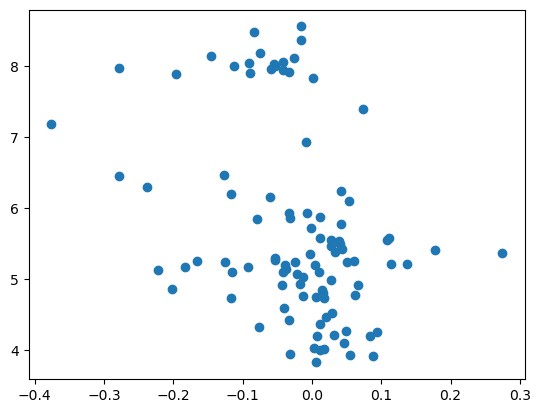

In [323]:
# Define independent variable.
y1 = FinBert_Unemployment_GBPUSD['Unemployment rate %'].values.reshape(-1, 1) 

# Define dependent variable.
X1 = FinBert_Unemployment_GBPUSD[['finbert_score']].values.reshape(-1, 1) 

# Check for linearity.
plt.scatter(X1,y1)

# Create model and print summary of metrics.

from sklearn import linear_model

# Fit the regression model.
lm1 = linear_model.LinearRegression()
lm1.fit(X1, y1) 


In [327]:
# Rename the column to avoid spaces and special characters
FinBert_Unemployment_GBPUSD = FinBert_Unemployment_GBPUSD.rename(columns={'Unemployment rate %': 'Unemployment_rate'})

# Now, pass the linear regression through OLS methods with the new column name
lm1_ols = ols('Unemployment_rate ~ finbert_score', data=FinBert_Unemployment_GBPUSD).fit()

# Print summary
print(lm1_ols.summary())


                            OLS Regression Results                            
Dep. Variable:      Unemployment_rate   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     14.06
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           0.000302
Time:                        21:39:20   Log-Likelihood:                -159.48
No. Observations:                  98   AIC:                             323.0
Df Residuals:                      96   BIC:                             328.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.5891      0.129     43.225

In [289]:
# Set the X coefficient and the constant to generate the regression table.
# Print the R-squared value.
print("R-squared: ", lm1.score(X1,y1))  # Correlation of the coefficient

# Print the intercept.
print("Intercept: ", lm1.intercept_) 

# Print the coefficients.
print("Coefficients:",lm1.coef_)  

# Map a similar index of multiple containers (to be used as a single entity).
list(zip(X1, lm1.coef_))  


R-squared:  0.12776332525290945
Intercept:  [5.58914955]
Coefficients: [[-4.87589107]]


[(array([-0.23767172]), array([-4.87589107]))]

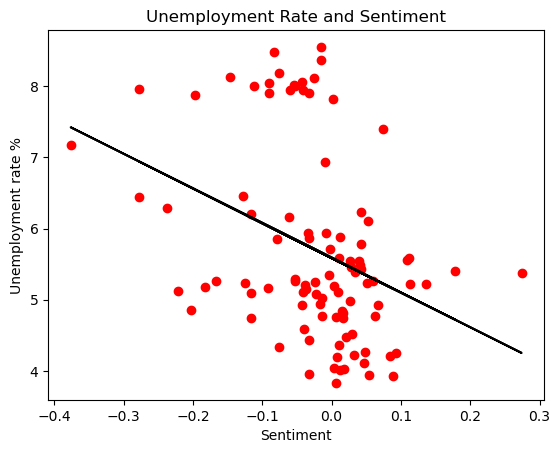

In [348]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot the graph with a regression line.
plt.scatter(X1, y1, color='red')

# Plot the best fit line
plt.plot(X1, lm1.predict(X1), color='black')

# Add titles and label
plt.title('Unemployment Rate and Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Unemployment rate %')

# Display plot
plt.show()


## GBP/USD (2007-2010)

LinearRegression()

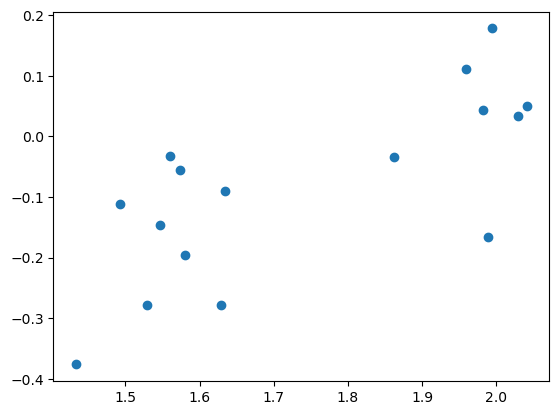

In [381]:
# Rename the column to avoid special characters
FinBert_Unemployment_GBPUSD_0710 = FinBert_Unemployment_GBPUSD_0710.rename(columns={'GBP/USD': 'GBP_USD'})

# Define independent variable.
y2 = FinBert_Unemployment_GBPUSD_0710['finbert_score'].values.reshape(-1, 1) 

# Define dependent variable.
X2 = FinBert_Unemployment_GBPUSD_0710['GBP_USD'].values.reshape(-1, 1) 

# Check for linearity.
plt.scatter(X2,y2)

# Create model and print summary of metrics.

# from sklearn import linear_model

# Fit the regression model.
lm2 = linear_model.LinearRegression()
lm2.fit(X2, y2) 


In [383]:
# Now, run the regression with the new column name
lm2_ols = ols('finbert_score ~ GBP_USD', data=FinBert_Unemployment_GBPUSD_0710).fit()

# Print summary
print(lm2_ols.summary())

                            OLS Regression Results                            
Dep. Variable:          finbert_score   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     15.98
Date:                Sat, 09 Nov 2024   Prob (F-statistic):            0.00132
Time:                        15:10:29   Log-Likelihood:                 14.065
No. Observations:                  16   AIC:                            -24.13
Df Residuals:                      14   BIC:                            -22.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9367      0.215     -4.359      0.0

In [396]:
# Set the X coefficient and the constant to generate the regression table.
# Print the R-squared value.
print("R-squared: ", lm2.score(X2,y2))  # Correlation of the coefficient

# Print the intercept.
print("Intercept: ", lm2.intercept_) 

# Print the coefficients.
print("Coefficients:",lm2.coef_)  

# Map a similar index of multiple containers (to be used as a single entity).
list(zip(X2, lm2.coef_))  


R-squared:  0.5330832202172856
Intercept:  [-0.93666352]
Coefficients: [[0.48993541]]


[(array([1.95950003]), array([0.48993541]))]

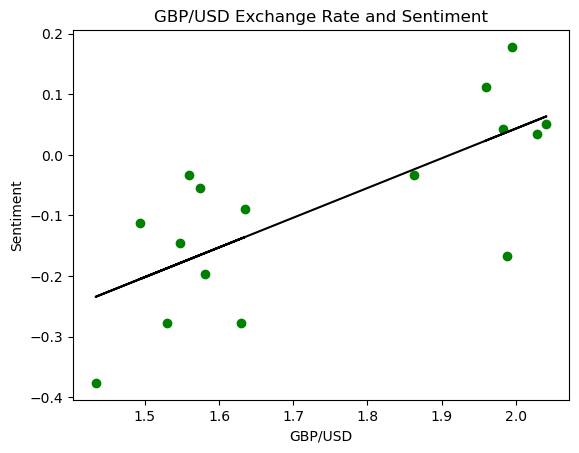

In [398]:
# Import necessary libraries
# import matplotlib.pyplot as plt

# Plot the graph with a regression line.
plt.scatter(X2, y2, color='green')

# Plot the best fit line
plt.plot(X2, lm2.predict(X2), color='black')

# Add titles and label
plt.title('GBP/USD Exchange Rate and Sentiment')
plt.xlabel('GBP/USD')
plt.ylabel('Sentiment')

# Display plot
plt.show()

Create New DataFrame (18-22)

### Unemployment Rate

### GBP/USD

# 7. Export Documents

In [ ]:
Unemployment_GBPUSD.to_excel('Unemployment_GBPUSD.xlsx', index=False)

In [402]:
FinBert_Unemployment_GBPUSD.to_excel('Sentiment_Unemployment_GBPUSD.xlsx', index=False)